# World Wide Products Inc.

Dalton Hahn (2762306)

## Product Data

https://www.kaggle.com/felixzhao/productdemandforecasting

## Goal

* Perform feature engineering on the dataset in order to enable time-series forecasting
* Use time-series forecasting to predict demand of a given product

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statistics import mean, stdev, median
import string
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA

In [2]:
## Throughout, was dealing with some warnings, but will suppress those to make the notebook cleaner
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("../data/external/Historical Product Demand.csv")
df = df.dropna()
print(df.shape)
df.head()

(1037336, 5)


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


## Exploring the Data

In [4]:
# Number of unique products and their labels

print(df['Product_Code'].unique())
print(len(df['Product_Code'].unique()))

['Product_0993' 'Product_0979' 'Product_1159' ... 'Product_0237'
 'Product_0644' 'Product_0853']
2160


In [5]:
# Number of unique warehouses and their labels

print(df['Warehouse'].unique())
print(len(df['Warehouse'].unique()))

['Whse_J' 'Whse_S' 'Whse_C' 'Whse_A']
4


In [6]:
# Number of Product Categories and their labels

print(df['Product_Category'].unique())
print(len(df['Product_Category'].unique()))

['Category_028' 'Category_006' 'Category_001' 'Category_019'
 'Category_005' 'Category_030' 'Category_032' 'Category_011'
 'Category_033' 'Category_007' 'Category_015' 'Category_021'
 'Category_024' 'Category_026' 'Category_023' 'Category_022'
 'Category_009' 'Category_003' 'Category_004' 'Category_018'
 'Category_020' 'Category_013' 'Category_008' 'Category_017'
 'Category_031' 'Category_025' 'Category_010' 'Category_029'
 'Category_012' 'Category_002' 'Category_014' 'Category_027'
 'Category_016']
33


In [7]:
# Range of Order Demand

# Some lines are NaN and some lines have parentheses, removing NaN's early on, processing parentheses lines here
counter = 0


for index, row in df.iterrows():
    if '(' in row['Order_Demand'] or ')' in row['Order_Demand']:
        row['Order_Demand'] = row['Order_Demand'].replace('(', '')
        row['Order_Demand'] = row['Order_Demand'].replace(')', '')
        row['Order_Demand'] = float(row['Order_Demand'])
    else:
        row['Order_Demand'] = float(row['Order_Demand'][:-1])
        


In [8]:
print(df['Order_Demand'].unique())

[100.0 500.0 50000.0 ... 1700000.0 497000.0 28250.0]


In [9]:
print(max(df['Order_Demand']))
print(min(df['Order_Demand']))
print(median(df['Order_Demand']))
print(mean(df['Order_Demand']))

4000000.0
0.0
300.0
4949.3837396947565


## Observations
- First glance, minimal product categories and warehouses
- Huge variation in order demand
- 2000+ products to choose from

Let's continue working with the data by separating the date portion into it's components

In [10]:
# Date splitting

months = []
days = []
years = []

for row in df['Date']:
    year = row.split('/')[0]
    years.append(year)
    #print(month)
    month = row.split('/')[1]
    months.append(month)
    #print(day)
    day = row.split('/')[2]
    days.append(day)

In [11]:
df.insert(len(df.columns), 'Month', months, True)
df.insert(len(df.columns), 'Day', days, True)
df.insert(len(df.columns), 'Year', years, True)

In [12]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Month,Day,Year
0,Product_0993,Whse_J,Category_028,2012/7/27,100,7,27,2012
1,Product_0979,Whse_J,Category_028,2012/1/19,500,1,19,2012
2,Product_0979,Whse_J,Category_028,2012/2/3,500,2,3,2012
3,Product_0979,Whse_J,Category_028,2012/2/9,500,2,9,2012
4,Product_0979,Whse_J,Category_028,2012/3/2,500,3,2,2012


## Plotting Data to look for Trends
- Specifically with Product_042

In [13]:
# Collecting relevant rows for Product_0042

df_prod = df[df.Product_Code == "Product_0042"]
print(df_prod.shape)

(129, 8)


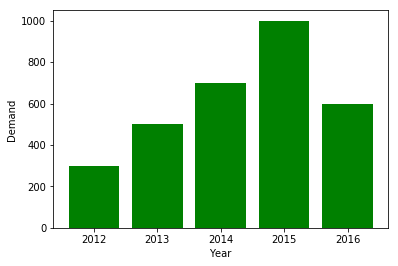

In [14]:
plt.bar(df_prod['Year'], df_prod['Order_Demand'], color='green')
plt.xlabel("Year")
plt.ylabel("Demand")
plt.show()


### Describing the demand in terms of year doesn't provide us a lot of information

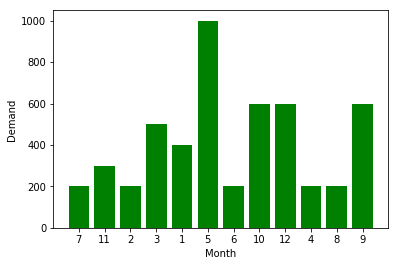

In [15]:
plt.bar(df_prod['Month'], df_prod['Order_Demand'], color='green')
plt.xlabel("Month")
plt.ylabel("Demand")
plt.show()

### The results from examining deman on a per-month basis is much better
- Fairly predictable price across months 9, 10, 12
- 6, 7, 8 pretty much the same as well

# Predicting Demand

In [16]:
le = preprocessing.LabelEncoder()
df_prod["Product_Category"] = le.fit_transform(df_prod["Product_Category"])
df_prod["Warehouse"] = le.fit_transform(df_prod["Warehouse"])

In [17]:
x = df_prod.drop(['Product_Code', 'Order_Demand', "Date", "Year", "Day"], axis=1)
y = df_prod['Order_Demand']

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5)
linearRegressor = LinearRegression()
linearRegressor.fit(xTrain, yTrain)
yPrediction = linearRegressor.predict(xTest)

errors = list()
counter = 0
for row in yTest:
    errors.append(yPrediction[counter]-row)
    #print("Pred: ", yPrediction[counter], "; True Val: ", row, "; Error: ", yPrediction[counter]-row)
    counter = counter + 1
    
print("Average error: ", mean(errors))
print("Largest positive error: ", max(errors))
print("Largest negative error: ", min(errors))

Average error:  -6.79600250495773
Largest positive error:  67.54862053369516
Largest negative error:  -833.4464043419267


## Horrendous results, there's a reason linear regression isn't good at this

## ARIMA

In [18]:
#Mostly concerned with order demand based on a date, let's drop other columns and just stick with those

df_prod = df_prod.drop(["Product_Code", "Warehouse", "Product_Category", "Month", "Day","Year"], axis=1)

# Convert my original date format to datetime
df_prod['Date'] = pd.to_datetime(df_prod['Date'])

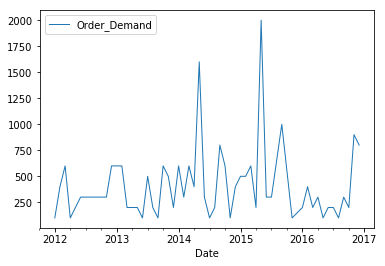

In [19]:
month_period = df_prod.Date.dt.to_period("M")
monthly_orders = df_prod.groupby(month_period).sum()
monthly_orders.plot(linewidth=1)

In [20]:

weekly = df_prod.groupby(pd.Grouper(key='Date', freq='W-MON')).sum().reset_index()

training = weekly.loc[weekly['Date'] <
                            pd.to_datetime('2016-1-1').date()]
testing = weekly.loc[weekly['Date'] >
                            pd.to_datetime('2015-12-31').date()]

In [21]:
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

# 0,3,0 ARIMA Model
ARIMA_model = ARIMA(training['Order_Demand'], order=(3,0,0))
ARIMA_model_fit = ARIMA_model.fit(disp=0)
print(ARIMA_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:           Order_Demand   No. Observations:                  206
Model:                     ARMA(3, 0)   Log Likelihood               -1393.524
Method:                       css-mle   S.D. of innovations            209.707
Date:                Wed, 30 Oct 2019   AIC                           2797.048
Time:                        13:49:00   BIC                           2813.688
Sample:                             0   HQIC                          2803.778
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 87.0197     12.608      6.902      0.000      62.308     111.731
ar.L1.Order_Demand    -0.0711      0.070     -1.023      0.308      -0.207       0.065
ar.L2.Order_Demand  

### The ARIMA model summary output provides us lots of statistical information as far as how the model is performing with the data, but let's try to see how it looks visually against the dataset

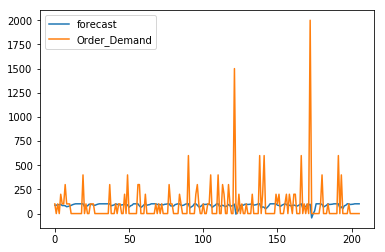

In [22]:
ARIMA_model_fit.plot_predict(dynamic=False)
plt.show()

### The forecast performance across the entire model is not great.  It's very flat and appears to have just done a simple averaging over the data

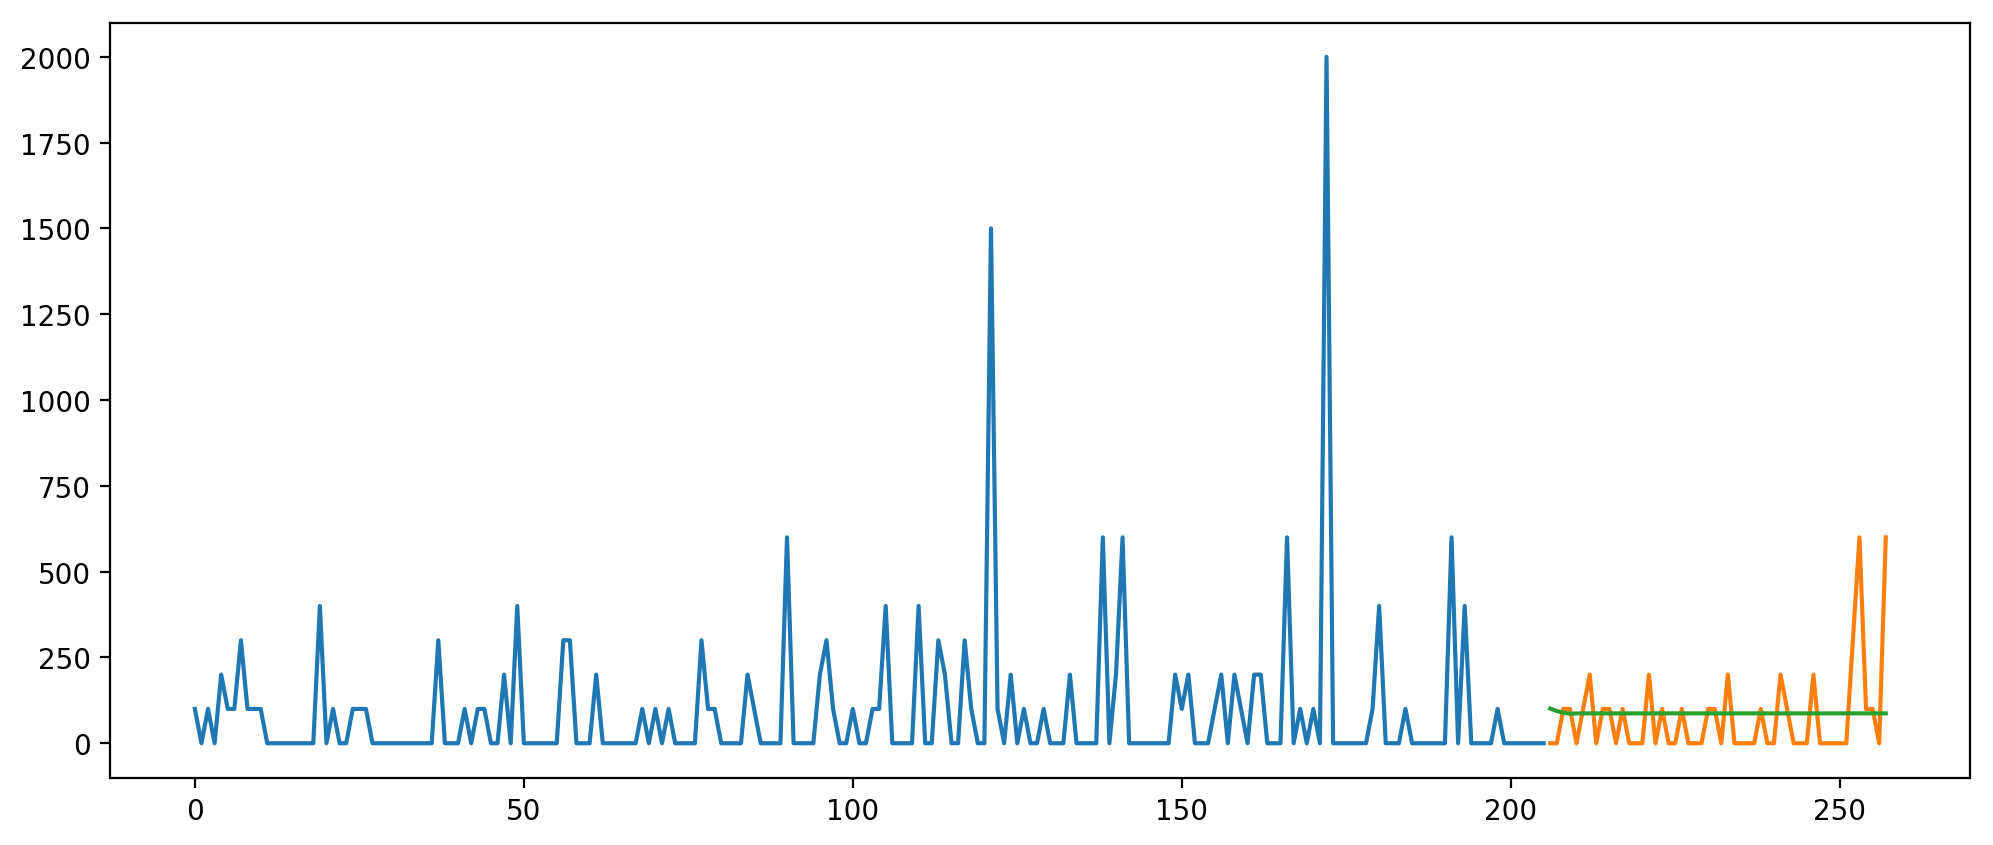

In [23]:
forecast, se, conf = ARIMA_model_fit.forecast(52, alpha=0.05)  # 95% conf

# Put into a series
forecast_series = pd.Series(forecast, index=testing.index)
lower_series = pd.Series(conf[:, 0], index=testing.index)
upper_series = pd.Series(conf[:, 1], index=testing.index)

# Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(training['Order_Demand'])
plt.plot(testing['Order_Demand'])
plt.plot(forecast_series)

plt.show()

## Conclusions
In the figure above, the blue line represents the actual historical data that was used to train upon.  The orange line represents the actual data observed and serves as the testing data.  And the green line represents the model's attempt to forecast the test data.  As you can see, the performance is quite poor.  I believe that this is the result mostly due to the fact that the data is very sporadic and very noisy, causing lots of issue with training the model.